In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.insert(0, '../..')
from scripts.utils.latex import add_colname, show_latex, TABLES

ModuleNotFoundError: No module named 'src'

In [2]:
pd.set_option("max_columns", None)

# Load data

In [3]:
path = Path('../../data/from_inception_tsv')
filenames = [
    'annotated_df_week_20_parsed.pkl',
    'annotated_df_week_21_partial_parsed_dedup.pkl',
    'annotated_df_ze_batch3_parsed.pkl',
]
df = pd.concat([pd.read_pickle(path / fn) for fn in filenames]).assign(
    disregard_note = lambda df: df.groupby('NotitieID').disregard.transform('max'),
)

In [6]:
def deduplicate_notes(df):
    """
    Some notes are annotated more than once, by different annotators.
    Select one of the annotators randomly per note and keep her/his annotation only.
    """
    choices = df.groupby('NotitieID').annotator.unique().apply(random.choice).reset_index()
    selected = list(choices.values)
    return df.loc[df.set_index(['NotitieID', 'annotator']).index.isin(selected)]

print(f"Before: {len(df)}")
df = deduplicate_notes(df)
print(f"After: {len(df)}")

Before: 155603
After: 149013


In [7]:
path = Path('../../data/to_inception_conll')
filenames = [
    'week_20.pkl',
    'week_21.pkl',
]
info = pd.concat([pd.read_pickle(path / fn) for fn in filenames])

In [8]:
df = df.merge(
    info[['NotitieID', 'MDN', 'source', 'samp_meth']],
    how='left',
    on=['NotitieID', 'MDN'],
)

# Annotated notes

In [9]:
caption = "Weeks 20-21: Number of annotated notes (incl. disregard)"
label = "w20-w21_annot_n_notes"

df.pivot_table(
    index='source',
    values='NotitieID',
    aggfunc='nunique',
    margins=True,
    margins_name='total',
).rename(columns={'NotitieID': 'n_notes'}
).join(
        df.query("disregard == True").pivot_table(
        index='source',
        values='NotitieID',
        aggfunc='nunique',
        margins=True,
        margins_name='total',
    ).rename(columns={'NotitieID': 'n_disregard'})
).assign(
    n_annotated=lambda df: df.n_notes - df.n_disregard,
    prc_disregard=lambda df: (df.n_disregard / df.n_notes).mul(100).round(1),
).pipe(show_latex, caption=caption, label=label)

,n_notes,n_disregard,n_annotated,prc_disregard
source,,,,
2017,145,9,136,6.2
2018,154,12,142,7.8
cov_2020,180,12,168,6.7
non_cov_2020,154,25,129,16.2
total,633,58,575,9.2


# Annotated sentences

In [10]:
# remove "disregard" notes

adjusted = df.query("disregard_note == False")

# select rows with domain labels
domains = ['ENR', 'ATT', 'STM', 'ADM', 'INS', 'MBW', 'FAC', 'BER', 'ETN']
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['source', 'sen_id'])[domains].any()

In [11]:
caption = "Weeks 20-21: Number of sentences with labels (excl. disregard)"
label = "w20-w21_annot_sents_w_labels"

n_sent = adjusted.groupby('source').sen_id.nunique()

n_sent_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('source').sen_id.nunique()

table = pd.concat([
    n_sent.rename('n_all_sents'),
    n_sent_with_label.rename('n_sents_with_labels'),
], axis=1)
table.loc['total'] = table.sum()
table.assign(prc_sents_with_labels=lambda df: (df.n_sents_with_labels / df.n_all_sents).mul(100).round(1)
).pipe(show_latex, caption=caption, label=label)

,n_all_sents,n_sents_with_labels,prc_sents_with_labels
source,,,
2017,"3,158",294,9.3
2018,"2,944",302,10.3
cov_2020,"4,517",445,9.9
non_cov_2020,"2,768",165,6.0
total,"13,387","1,206",9.0


# Distribution of domains

In [12]:
caption = "Weeks 20-21: Distribution of domains"
label = "w20-w21_annot_domains"

n_labels = domain_totals_per_sen_id.pivot_table(
    index='source',
    values=domains,
    aggfunc='sum',
    margins=True,
    margins_name='total',
).assign(total=lambda df: df.sum(axis=1))

p_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round()

piv = n_labels.pipe(add_colname, 'n').join(
    p_labels.pipe(add_colname, '%')
).astype('Int64'
).sort_index(axis=1, level=[0,1], ascending=[True, False])

piv.pipe(show_latex, caption=caption, label=label)

ADM     ATT    BER    ENR     ETN      FAC     INS      MBW      \
                n   %   n  %   n  %   n  %    n   %    n   %   n   %    n   %   
source                                                                          
2017           19   6   0  0   8  3  12  4  148  47   39  12  17   5   50  16   
2018           28   8   3  1   1  0  19  6  165  49   34  10  22   7   42  13   
cov_2020       90  19  15  3  14  3  34  7  138  30   55  12  46  10   38   8   
non_cov_2020   19  11   8  5   5  3   8  5   52  31   24  14  12   7    9   5   
total         156  12  26  2  28  2  73  6  503  39  152  12  97   8  139  11   

              STM      total       
                n   %      n    %  
source                             
2017           25   8    318  100  
2018           20   6    334  100  
cov_2020       37   8    467  100  
non_cov_2020   33  19    170  100  
total         115   9  1,289  100

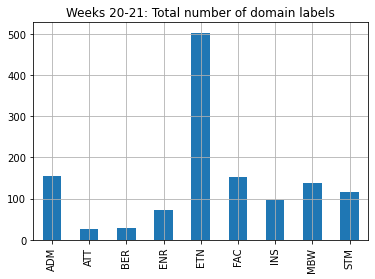

In [13]:
# total number of labels

fig, ax = plt.subplots(figsize=(6, 4))
piv.loc[['total']].xs('n', axis=1, level=1).iloc[:,:-1].T.plot.bar(
    ax=ax,
    legend=False, 
    grid=True, 
    title='Weeks 20-21: Total number of domain labels',
)
fig.savefig('figures/w20-w21_total_n_domains.png')

# Distribution of levels per domain

In [14]:
caption = "Weeks 20-21: Distribution of levels per domain"
label = "w20-w21_annot_levels"

stats = []
for lvl in [f"{i}_lvl" for i in domains]:
    notna = adjusted.loc[adjusted[lvl].notna()]
    stat = notna.groupby(['source', 'sen_id'])[lvl].apply(lambda s: {i for i in s if i==i})
    stat = stat.explode().groupby(level=0).value_counts()
    stats.append(stat)
table = pd.concat(stats, axis=1)
table = table.append(pd.concat([table.groupby(level=1).sum()], keys=['total']))
table.index = pd.MultiIndex.from_tuples([(i,int(j)) for i,j in table.index])
# sums = table.groupby(level=0).sum()
# sums.index = pd.MultiIndex.from_tuples([(i, 'total') for i in sums.index])
# table = pd.concat([table, sums]).sort_index(level=0)
table.pipe(show_latex, caption=caption, label=label)

ENR_lvl ATT_lvl STM_lvl ADM_lvl INS_lvl MBW_lvl FAC_lvl  \
2017         0     nan     nan     nan     nan     nan     nan     4.0   
             1     6.0     nan     3.0    10.0     8.0    12.0     1.0   
             2     6.0     nan    12.0     6.0     6.0    21.0     2.0   
             3     1.0     nan     4.0     1.0     2.0     9.0     6.0   
             4     nan     nan     6.0     7.0     nan    12.0    27.0   
             5     nan     nan     nan     nan     1.0     nan     4.0   
2018         0     nan     nan     nan     3.0     3.0     nan     nan   
             1     9.0     3.0     4.0     4.0     1.0    13.0     1.0   
             2     9.0     nan     6.0    11.0     9.0    23.0     6.0   
             3     1.0     nan     3.0     7.0     5.0     4.0     nan   
             4     nan     nan     9.0     4.0     5.0     4.0    28.0   
             5     nan     nan     nan     nan     2.0     nan     1.0   
cov_2020     0     nan     1.0     1.0    25.0     3.0     nan     4.0   
             1     5.0     3.0     3.0    14.0     4.0    13.0     1.0   
             2    20.0     7.0    15.0    25.0    16.0    11.0     2.0   
             3     7.0     1.0     6.0    26.0    12.0     9.0    12.0   
             4     3.0     3.0    12.0     5.0     8.0     9.0    39.0   
             5     nan     nan     nan     nan     2.0     nan     1.0   
non_cov_2020 0     nan     nan     nan     4.0     2.0     nan     3.0   
             1     4.0     1.0     5.0     3.0     5.0     7.0     nan   
             2     4.0     5.0    14.0     4.0     2.0     3.0     1.0   
             3     nan     2.0     7.0     2.0     2.0     2.0     6.0   
             4     nan     nan     9.0    10.0     nan     nan    14.0   
             5     nan     nan     nan     nan     nan     nan     2.0   
total        0     0.0     1.0     1.0    32.0     8.0     0.0    11.0   
             1    24.0     7.0    15.0    31.0    18.0    45.0     3.0   
             2    39.0    12.0    47.0    46.0    33.0    58.0    11.0   
             3     9.0     3.0    20.0    36.0    21.0    24.0    24.0   
             4     3.0     3.0    36.0    26.0    13.0    25.0   108.0   
             5     0.0     0.0     0.0     0.0     5.0     0.0     8.0   

               BER_lvl ETN_lvl  
2017         0     2.0    12.0  
             1     nan    49.0  
             2     2.0    65.0  
             3     1.0    14.0  
             4     3.0    16.0  
             5     nan     nan  
2018         0     nan    20.0  
             1     nan    67.0  
             2     nan    58.0  
             3     nan    17.0  
             4     1.0     8.0  
             5     nan     nan  
cov_2020     0     6.0    18.0  
             1     nan    33.0  
             2     nan    81.0  
             3     nan     6.0  
             4     9.0     7.0  
             5     nan     nan  
non_cov_2020 0     4.0     4.0  
             1     nan    18.0  
             2     nan    21.0  
             3     nan     8.0  
             4     1.0     3.0  
             5     nan     nan  
total        0    12.0    54.0  
             1     0.0   167.0  
             2     2.0   225.0  
             3     1.0    45.0  
             4    14.0    34.0  
             5     0.0     0.0

/data/homedirs/jenia/.conda/envs/zonmw/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


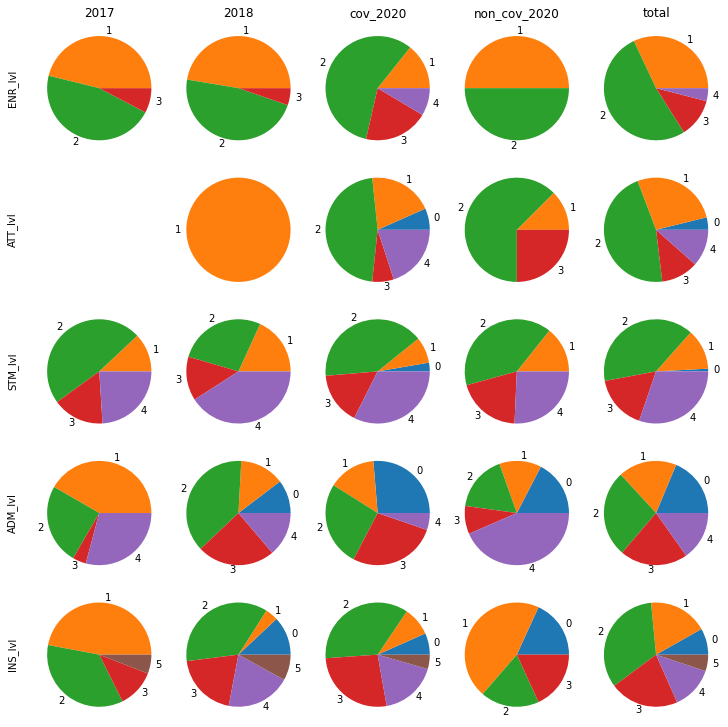

In [15]:
cols = table.index.levels[0]
rows = table.columns[:5]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w20-w21_levels_part1.png')

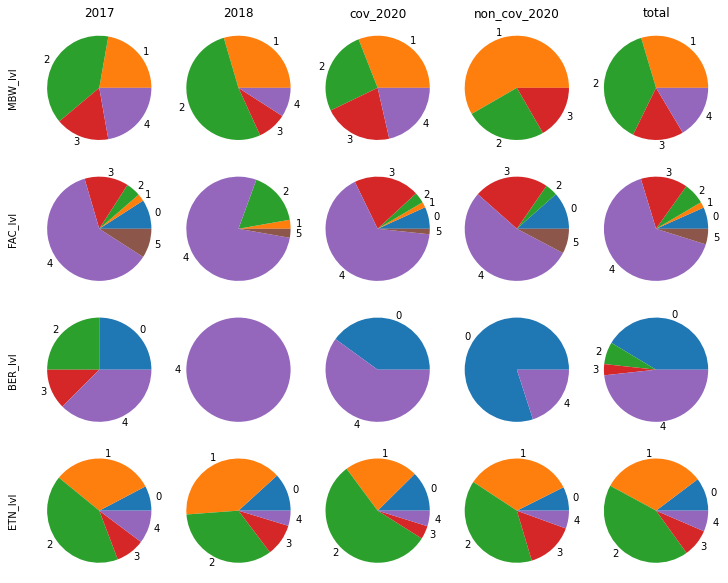

In [16]:
cols = table.index.levels[0]
rows = table.columns[5:]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w20-w21_levels_part2.png')

# Randomly-selected notes vs. Keyword-selected notes

In [17]:
# % disregard notes (out of all notes)
compare_samp = df.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
).groupby(['samp_meth']).apply(
    lambda grp: grp.groupby('NotitieID').disregard_note.first().agg({'n':'size', 'p':'sum'})
)
pct_disregard = (compare_samp.p / compare_samp.n).mul(100).round(1).rename(r'% disregard notes')

# % sentences with labels (out of all sents, excl. disregard)
adjusted = adjusted.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
)
n_sents = adjusted.groupby('samp_meth').sen_id.nunique()

n_sents_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('samp_meth').sen_id.nunique()

pct_sents_with_label = (n_sents_with_label / n_sents).mul(100).round(1).rename(r'% sentences with labels')

# distribution of domains
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['samp_meth', 'sen_id'])[domains].any()

n_labels = domain_totals_per_sen_id.pivot_table(
    index='samp_meth',
    values=domains,
    aggfunc='sum',
).assign(total=lambda df: df.sum(axis=1))

pct_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round(1).iloc[:,:-1]

# put everything together
caption = "Weeks 20-21: Comparison between randomly-selected and keyword-selected notes"
label = "w20-w21_annot_kwd_vs_rndm"

pd.concat([pct_disregard, pct_sents_with_label, pct_labels], axis=1).T.pipe(show_latex, caption=caption, label=label)

samp_meth,kwd,rndm
% disregard notes,11.1,5.9
% sentences with labels,8.9,9.4
ADM,11.8,13.0
ATT,2.4,0.9
BER,2.7,0.6
ENR,5.8,5.3
ETN,37.8,42.5
FAC,12.1,10.9
INS,7.1,8.8
MBW,11.4,9.1


In [18]:
prefix = 'w20-w21_annot'
for idx, table in enumerate(TABLES):
    with open(f'./tables/{prefix}_{idx}.tex', 'w', encoding='utf8') as f:
        f.write(table)